# Creating an 850mb multi-panel plot

This notebook will walk you through creating an easily customizable multi-panel 850mb plot with RAP 850mb winds and isotherms, base reflectivity from multiple radar stations and LMA points plotted.

**Created by: Ezekiel Caldon (SUNY Oswego) as part of the Lake-Effect Electrification (NSF-LEE) Project, funded by the National Science Foundation**

**Parts of code from Dr. Eric Bruning (Texas Tech), Dr. Vanna Chmielewski (NSSL) & Dr. Jake Mulholland (SUNY Albany)**

## Import packages and map features and configure color maps...

Some modules have instructions to install in the comments next to their import statements for your convenience, as their installations may not be readily obvious through a standard Google search.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd # http://pandas.pydata.org/
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyart
import glob
import datetime as dt
import nexradaws
conn = nexradaws.NexradAwsInterface()
from metpy.plots import USCOUNTIES
from pyxlma.lmalib.io import read as lma_read
import metview as mv # conda install metview  -c conda-forge & conda install metview-python  -c conda-forge
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none',linewidth=5)

# Gives some additional options for ZDR color maps, use 'zdrcolors1' or 'zdrcolors2'
colors1 = plt.cm.binary_r(np.linspace(0.2,0.8,33))
colors2= plt.cm.gnuplot_r(np.linspace(0.,0.7,100))
colors = np.vstack((colors1, colors2[10:121]))
kdpcolors = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
colors1 = plt.cm.binary_r(np.linspace(0.,0.8,33))
colors2= plt.cm.gist_ncar(np.linspace(0.,1,100))
colors = np.vstack((colors1, colors2[10:121]))
zdrcolors = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Customize your plot... 

### Specify the geographical area, times, titles, of your subplots, and customize the number of columns and rows and the save location for the figure... 

In [11]:
data_area = [46.5, -85, 41, -75] # North lat, West lon, South lat, East lon to plot in all subplots
times = [dt.datetime(2022,11,18,8,10), # Time for each subplot. This will be the midpoint for any LMA datasets used.
         dt.datetime(2022,11,18,10,20), # The closest radar file to the time will be plotted.
         dt.datetime(2022,11,18,15,10), 
         dt.datetime(2022,11,18,22,30),
         dt.datetime(2022,11,19,1,20),
         dt.datetime(2022,11,19,2,40)]
titles=['', '', '', '', '', ''] # Title for each subplot. The time for the subplot is automatically added after this title.
num_col = 3 # Number of columns for subplot cells
num_rows = 2 # Number of rows for subplot cells
# Directory to save the finished figure to, make sure there's a slash at the end!
save_dir = '/Users/zeke/oswego/research_projects/lee/Code/lmaworkshop/LEE-2023/850mb_plots/figures/'

### Toggle the radar layer, and specify sites, fields, sweeps, color maps and more...

Enable the radar layer to display radar data from one or multiple WSR-88D stations on your plots, with full control over the field, sweep, and color map. Radar files will download automatically into a directory named `radar`.

Possible fields from WSR-88D radars (for `radar_fields`): 
- `'cross_correlation_ratio'`
- `'spectrum_width'`
- `'differential_phase'`
- `'differential_reflectivity'`
- `'velocity'`
- `'reflectivity'`
- `'clutter_filter_power_removed'`

[Guidance for choosing a colormap for PyART](https://arm-doe.github.io/pyart/examples/plotting/plot_choose_a_colormap.html)

`kdpcolors` has been initialized in the import statements as a good KDP colormap.

`zdrcolors` has been initialized in the import statements as a good ZDR colormap.

In [3]:
radar_on = True # Enable radar layer?

radar_id = ['KTYX', 'KBUF', 'KDTX', 'KAPX'] # Add as many or as few radars as you'd like to the radar_id list.
radar_fields = ['reflectivity', 'reflectivity', 'reflectivity', 'reflectivity', 'reflectivity', 'reflectivity'] # List of fields for each pane
sweep=[0,0,0,0,0,0] # List of sweeps for each pane

multi_color_bar = False # If you are plotting different radar fields in each pane, toggle to True
radar_single_axis_title = 'Reflectivity (dBZ)' # If each field is the same, put the axis title here.
radar_multi_axis_titles = ['dBZ', '', '', '', '', ''] # Put axis titles in this list. If you have multi_color_bar = False, leave '' placeholders for the number of subplots you have.
multi_colorbar_orientation = 'vertical'

radar_cmaps = ['HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow'] # List of color maps for each pane
value_min = [10, 10, 10, 10, 10, 10] # Minimum value for each pane's color map
value_max = [50, 50, 50, 50, 50, 50] # Maximum value for each pane's color map

time_range = 12 # Configure the time range (in minutes) that the program will search for radar images after the configured times.

### Toggle the RAP analysis layer and specify the file directory, line and wind barb options...

Enable the RAP layer to display 850mb isotherms and wind barbs on your plot.

RAP files must be downloaded manually. Download them into a directory on your machine and copy that directory's path to the `RAP_dir` variable. [RAP files can be downloaded here.](https://www.ncei.noaa.gov/data/rapid-refresh/access/rap-130-13km/analysis/)

[For help specifying colors for MatPlotLib, go here](https://matplotlib.org/stable/users/explain/colors/colors.html#sphx-glr-users-explain-colors-colors-py).

In [4]:
# RAP
rap_on = True # Enable rap layer?

RAP_dir = '/Users/zeke/oswego/research_projects/lee/Code/lmaworkshop/LEE-2023/850mb_plots/notebooks/rap/' # Directory with RAP files, make sure there's a slash at the end

therm_line_width = 1.5 # Width of isotherm lines
isotherm_color = 'r' # Isotherm color.
inline_tf = True # Toggle inline isotherm labels
inline_space = 1 # Isotherm inline whitespace for labels
levels = np.arange(-30,30,2) # Specify isotherm levels (min, max, step)

wind_barb_spacing = 0.2 # Spacing of barbs on wind barbs
wind_barb_size = 6 # Size of wind barbs

### Toggle the LMA layer and specify the file directory, filter and plotting options...

LMA h5 flash files are downloaded automatically. [If you have trouble downloading with the code, .h5 files can be downloaded here.](https://data.nssl.noaa.gov/thredds/catalog/WRDD/OKLMA/deployments/flashsort_6/h5_files/catalog.html)

[For help specifying colors for MatPlotLib, go here](https://matplotlib.org/stable/users/explain/colors/colors.html#sphx-glr-users-explain-colors-colors-py).

[For a list of point markers for MatPlotLib, go here](https://matplotlib.org/stable/api/markers_api.html#module-matplotlib.markers)

In [5]:
lma_on = True # Enable lma layer?

min_events_per_flash = 10 # Minimum number of sources per flash
min_stations = 6 # more stations = more confident it's a good solution
max_chi = 1 # lower chi^2 = more confident it's a good solution
tbuffer = 15*60 # range for LMA data after specified time in seconds

lma_point_color = 'fuchsia' # LMA point color.
lma_point_size = 50 # LMA point size
lma_point_marker = '^' # LMA point marker.

## Setting things up and declaring functions for the plot

In [6]:
projection = ccrs.PlateCarree()
display = []
base_wid = 6
base_hei = 4
if ((multi_color_bar == True) & (radar_on == True)):
    base_wid = base_wid + 0.5
    base_hei = base_hei + 0.5
fig_wid = num_col * base_wid
fig_hei = num_rows * base_hei

In [7]:
def plot_radar_grid(ax, time, num):
    if radar_on == True:
        grid_file = f'grids/{time:%Y%m%d%H%M}_{num}.nc'
        if glob.glob(grid_file) != []:
            mesh_mapped_ALL = pyart.io.read_grid(grid_file)
        else:
            which_file = 0
            radars = []
            ktyx_starttime = []
            for i in radar_id:
                downloadloc = f'radar/{time:%Y%m%d%H%M}_{i}'
                if (glob.glob(f'{downloadloc}/*V06') == []):
                    scans = conn.get_avail_scans_in_range(time, time + dt.timedelta(minutes=time_range), i)
                    print(scans)
                    results = conn.download(scans, downloadloc)
                files = sorted(glob.glob(f'{downloadloc}/*V06'))
                ktyx_times = [dt.datetime.strptime((ktyx_file.split('/')[-1])[4:],"%Y%m%d_%H%M%S_V06") 
                          for ktyx_file in files]
                radars.append(pyart.io.read(files[which_file]))
                ktyx_starttimes = [dt.datetime.strptime((ktyx_file.split('/')[-1])[4:],"%Y%m%d_%H%M%S_V06")
                          for ktyx_file in files]
                ktyx_starttime.append(ktyx_starttimes[which_file])
            mesh_mapped_ALL = [None] * (len(radar_id))
            radar_tuple = []
            for j in range(len(radar_id)):
                radar_tuple.append(radars[j])
            mesh_mapped_ALL = pyart.map.grid_from_radars(
                (tuple(radar_tuple)),  
                grid_shape=(1, 301, 301),
                grid_limits=((1000, 1000), 
                             (-500.*1000., 500.*1000.), 
                             (-500.*1000., 500.*1000.)),
                grid_origin = (43.75, -80),
                fields=[radar_fields[num]],
                refl_field=radar_fields[num],
                max_refl=100.,
                copy_field_data=False)
            os.makedirs('grids', exist_ok=True)
            pyart.io.write_grid(grid_file, mesh_mapped_ALL)
        display.append(pyart.graph.GridMapDisplay(mesh_mapped_ALL))
        display[num].plot_grid(radar_fields[num], sweep[num], vmin=value_min[num], vmax=value_max[num], 
                             colorbar_label=radar_multi_axis_titles[num], title_flag=False,
                             cmap=radar_cmaps[num], colorbar_flag=multi_color_bar, ax=ax,
                             projection=projection, colorbar_orient=multi_colorbar_orientation,
                             lon_lines=None, lat_lines=None, add_grid_lines=False, embellish=False)

In [8]:
def plot_rap_data(time, ax):
    if rap_on == True:
        filename = None
        filename = glob.glob('{}r*{}00_000.grb2'.format(RAP_dir, time.strftime('%Y%m%d_%H')))
        if (filename == []):
            filename = glob.glob('{}r*{}00_000.grb2'.format(RAP_dir, (time.strftime('%Y%m%d_') + ((time + dt.timedelta(hours=1)).strftime('%H')))))
        i = pygrib.open(filename[0])
        data = mv.read(source=filename[0], area=data_area, grid=[0.1,0.1])
        t= data.select(shortName='t', level=850)
        mv.write((filename[0][:-5] + '_c.grb2'), t)
        
        grb = i.select()[192]
        lat, lon = grb.latlons()
        U85=(grb.values[:,:])
        grb = i.select()[193] 
        V85=(grb.values[:,:])  
        lat_u, lon_u = grb.latlons()
        
        o_file = pygrib.open(filename[0][:-5] + '_c.grb2')
        grb = o_file.select()[0] 
        T85=(grb.values[:,:])-(273.15)
        lat_u_t,lon_u_t = grb.latlons()
    
        CS = ax.contour(lon_u_t, lat_u_t, T85, levels, colors=isotherm_color,linewidths=therm_line_width, transform=ccrs.PlateCarree())
        ax.clabel(CS, fontsize=12, fmt='%1.0f', inline=inline_tf, inline_spacing=inline_space)
        ax.barbs(lon_u[::5,::5],lat_u[::5,::5],U85[::5,::5],V85[::5,::5],transform=ccrs.PlateCarree(),
             sizes=dict(emptybarb=0.1, spacing=wind_barb_spacing, height=0.35),length=wind_barb_size,flip_barb=False,zorder=1)

In [9]:
def plot_LMA_flash_data(start):
    if lma_on == True:
        filenames = []
        flashes = []
        flash_event_time = []
        flash_events = []
        selection_event = []
        lma_lon = []
        lma_lat = []
        filename = 'lma/LYLOUT_{}000_0600.dat.flash.h5'.format(start.strftime('%y%m%d_%H%M')[:-1])
        filenames.append(filename)
        if (glob.glob(filename) == []):
            url = 'https://data.nssl.noaa.gov/thredds/fileServer/WRDD/OKLMA/deployments/flashsort_6/h5_files/{}/{}'.format(start.strftime('%Y/%m/%d'),filename[4:])
            response = requests.get(url)
            with open(filename, "wb") as file:
                file.write(response.content)
            print(f'{filename} downloaded successfully.')
        if (tbuffer > 600):
            for i in range(int(tbuffer/600)):
                filename = 'lma/LYLOUT_{}000_0600.dat.flash.h5'.format((start+dt.timedelta(seconds=(i*600))).strftime('%y%m%d_%H%M')[:-1])
                filenames.append(filename)
                if (glob.glob(filename) == []):
                    url = 'https://data.nssl.noaa.gov/thredds/fileServer/WRDD/OKLMA/deployments/flashsort_6/h5_files/{}/{}'.format(start+dt.timedelta(seconds=(i*600)).strftime('%Y/%m/%d'),filename[4:])
                    response = requests.get(url)
                    with open(filename, "wb") as file:
                        file.write(response.content)
                    print(f'{filename} downloaded successfully.')
        filename = 'lma/LYLOUT_{}000_0600.dat.flash.h5'.format((start+dt.timedelta(seconds=tbuffer)).strftime('%y%m%d_%H%M')[:-1])
        if filename not in filenames:
            filenames.append(filename)
            if (glob.glob(filename) == []):
                    url = 'https://data.nssl.noaa.gov/thredds/fileServer/WRDD/OKLMA/deployments/flashsort_6/h5_files/{}/{}'.format((start+dt.timedelta(seconds=tbuffer)).strftime('%Y/%m/%d'),filename[4:])
                    response = requests.get(url)
                    with open(filename, "wb") as file:
                        file.write(response.content)
                    print(f'{filename} downloaded successfully.')
        flashes = pd.DataFrame()
        flash_events = pd.DataFrame()
        for filename in filenames:
            timeobj = dt.datetime.strptime(filename.split('/')[-1], 
                                           "LYLOUT_%y%m%d_%H%M%S_0600.dat.flash.h5")
            # This is the flash table
            flashes2 = pd.read_hdf(filename,'flashes/LMA_{}00_600'.format(
                                            timeobj.strftime('%y%m%d_%H%M')))
            # This is the event (VHF source) table
            flash_events2 = pd.read_hdf(filename,'events/LMA_{}00_600'.format(
                                            timeobj.strftime('%y%m%d_%H%M')))
            # Flash ID's are not unique between files. This writes new ones 
            # in the second file, if it exists
            if flashes.shape[0]>0:
                flashes2.flash_id      = flashes2['flash_id']     +flashes.flash_id.max()+1
                flash_events2.flash_id = flash_events2['flash_id']+flashes.flash_id.max()+1
            else:
                pass
            flashes      = pd.concat([flashes,flashes2])
            flash_events = pd.concat([flash_events,flash_events2])         

        # Make a series of datetime objects for each event
        flash_event_time = np.array([dt.datetime(*start.timetuple()[:3])+dt.timedelta(seconds = j) for j in flash_events.time])
        try:
            # Select all the sources meeting the criteria set above
            selection_event = (flash_event_time>=start)&(flash_event_time < start+dt.timedelta(seconds=tbuffer))&(flash_events.chi2<=max_chi)&(flash_events.stations>=min_stations)
            
            lma_lon = (flash_events.lon[selection_event].values)
            
            lma_lat = (flash_events.lat[selection_event].values)
            
        except AttributeError:
            pass
        try:
            # Only those in flashes and meeting criteria set above
            if flash_events.empty == False:
                for flash in flashes.flash_id[flashes.n_points>=min_events_per_flash]:
                    if (any ((flash_events.flash_id[selection_event]==flash) == True)):
                        plt.scatter(lma_lon[(flash_events.flash_id[selection_event]==flash)][0],
                                    lma_lat[(flash_events.flash_id[selection_event]==flash)][0],
                                    color=lma_point_color,s=lma_point_size,marker=lma_point_marker)
        except NameError:
            pass

## Plot code

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zeke/oswego/research_projects/lee/Code/lmaworkshop/LEE-2023/850mb_plots/figures/850mbplot/850mbplot22111808.png'

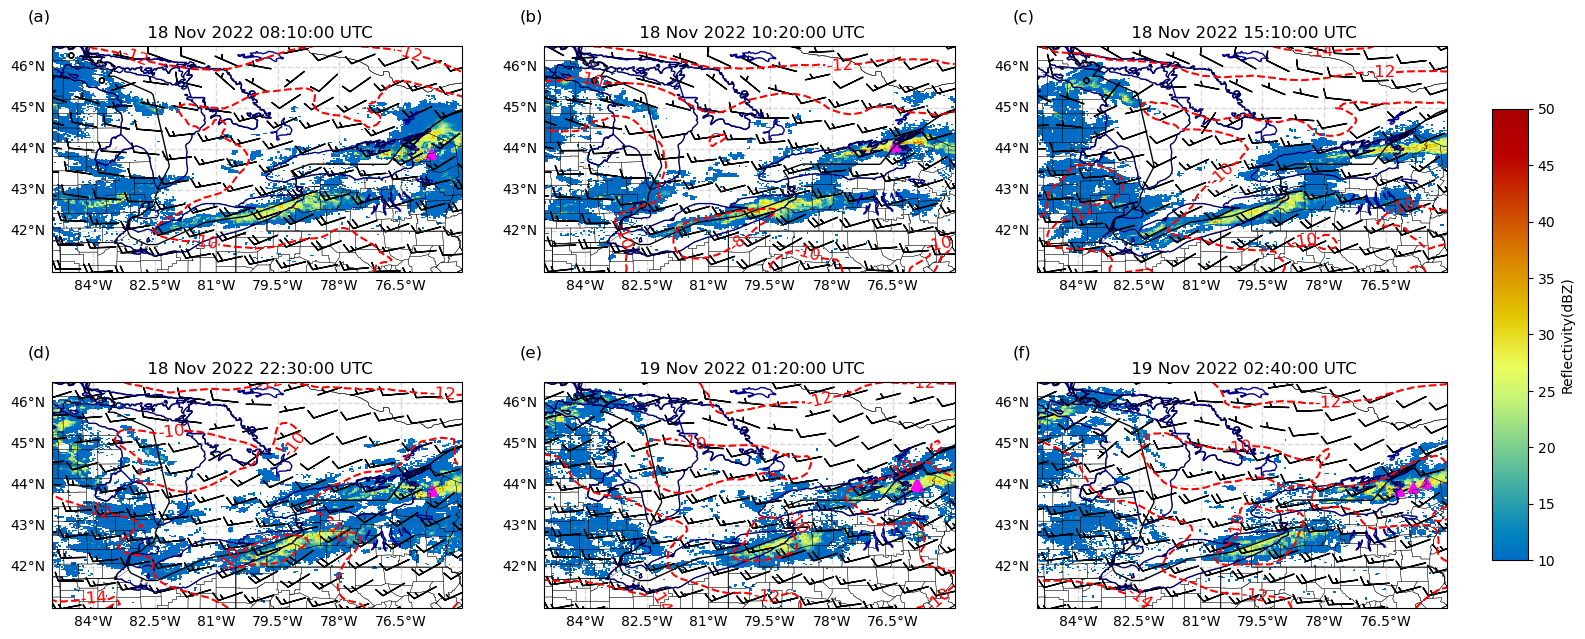

In [10]:
fig = plt.figure(figsize = (fig_wid,fig_hei))
ax = []

for i in range(num_col*num_rows):
    ax.append(fig.add_subplot(num_rows, num_col, i+1, aspect='equal', projection=projection))
    plot_radar_grid(ax[i], times[i], i)
    ax[i].set_title(titles[0] + ' {} UTC'.format(times[i].strftime('%d %b %Y %H:%M:%S')))
    # Add gridlines
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,color="gray",alpha=0.3,linestyle="--",)
    gl.right_labels = False
    gl.top_labels = False
    
    ax[i].set_extent([data_area[1], data_area[3], data_area[2], data_area[0]], ccrs.PlateCarree())
    
    ax[i].add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.25)
    ax[i].add_feature(cfeature.LAKES, facecolor='None',edgecolor='darkblue', linewidth=1)
    ax[i].add_feature(cfeature.COASTLINE,edgecolor='black',linewidth=1)
    ax[i].add_feature(cfeature.BORDERS,edgecolor='black',linewidth=1)
    ax[i].add_feature(states_provinces, edgecolor='black',linewidth=0.25)
    ax[i].add_feature(cfeature.STATES, edgecolor='black', linewidth=0.25)
    
    plot_rap_data(times[i], ax[i])
    
    plot_LMA_flash_data(times[i]-dt.timedelta(seconds = (tbuffer/2)))
    char = chr(97+i)
    
    ax[i].text((data_area[1]-.6),(data_area[0]+.6),'(' + char + ')', fontsize=12)
    

if ((multi_color_bar == False) & (radar_on == True)):
    cbar_ax = fig.add_axes([ax[num_col-1].get_position().x1 + 0.025,
                         ax[num_col-1].get_position().y0-.36,
                         0.02,
                         (ax[num_col-1].get_position().height*2)])
    display[(num_col*num_rows)-1].plot_colorbar(field=radar_fields[0], orientation='vertical', cax=cbar_ax, fig=fig)
elif ((multi_color_bar == True) & (radar_on == True)):
    plt.tight_layout()

plt.savefig(save_dir + '850mbplot' + times[0].strftime('%y%m%d%H') + '.png', dpi=500, facecolor='white')
plt.show()